In [1]:
import math
import os
import sys
import random
from pathlib import Path
import numpy as np
from numpy.linalg import pinv,inv
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from itertools import starmap

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import warnings
warnings.simplefilter("ignore", UserWarning)

from tqdm import tqdm
import string
from aim import Run
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import ClassLabel, DatasetDict, load_dataset, load_metric, Dataset, concatenate_datasets
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import transformers
from accelerate import Accelerator
from huggingface_hub import Repository
from transformers import (
    CONFIG_MAPPING,
    MODEL_MAPPING,
    AdamW,
    AutoConfig,
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    set_seed,
)
from transformers.file_utils import get_full_repo_name
from transformers.utils.versions import require_version

from run_ner_no_trainer import read_ner_data, evaluate, get_labels, compute_metrics

In [2]:
# Model Paths
# models/domain_en_de_zh_epoch_50
# models/domain_es_epoch_50
# classifiers/domain_en_de_zh_epoch_50_en_de_zh_es_epoch_50
# classifiers/domain_en_de_zh_epoch_50_es_epoch_50


path = '/mnt/xtb/knarik/outputs/DG/models/domain_en_de_zh_epoch_50'
DATA_DIR = 'data/ner'

model = AutoModelForTokenClassification.from_pretrained(path, output_hidden_states=True, num_labels=9)                         

In [3]:
model 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [4]:
accelerator = Accelerator()
model = accelerator.prepare(model)

In [5]:
TRAIN_LANGS = ["en", "zh", "es", "de", "nl"]
train_size = 8323


lang_datasets = {
    'en_test':  Dataset.from_dict(read_ner_data(os.path.join(DATA_DIR, 'test.txt'))),
    'de_test':  Dataset.from_dict(read_ner_data(os.path.join(DATA_DIR, 'deu.testb.txt'))),
    'es_test':  Dataset.from_dict(read_ner_data(os.path.join(DATA_DIR, 'esp.testb.txt'))),
    'nl_test':  Dataset.from_dict(read_ner_data(os.path.join(DATA_DIR, 'ned.testb.txt'))),
    'zh_test':  Dataset.from_dict(read_ner_data(os.path.join(DATA_DIR, 'msra_test_bio.txt')))
}    


In [6]:
raw_datasets = DatasetDict()
raw_datasets.update(lang_datasets)

print(raw_datasets)

DatasetDict({
    en_test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
    de_test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3005
    })
    es_test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1517
    })
    nl_test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 5195
    })
    zh_test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3442
    })
})


In [7]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased', use_fast=True)   

In [8]:
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

In [9]:
label_list = get_label_list(lang_datasets["en_test"]['ner_tags'])
label_to_id = {l: i for i, l in enumerate(label_list)}    
label_to_id

{'B-LOC': 0,
 'B-MISC': 1,
 'B-ORG': 2,
 'B-PER': 3,
 'I-LOC': 4,
 'I-MISC': 5,
 'I-ORG': 6,
 'I-PER': 7,
 'O': 8}

In [10]:
label_list

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [11]:
def tokenize_and_align_labels(examples):
        label_column_name = 'ner_tags'
        text_column_name = 'tokens'
    
        tokenized_inputs = tokenizer(
            examples[text_column_name],
            max_length=96,
            padding=False,
            truncation=True,
            # We use this argument because the texts in our dataset are lists of words (with a label for each word).
            is_split_into_words=True,
        )

        labels = []
        for i, label in enumerate(examples[label_column_name]):            
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            label_ids = []
            
            for word_idx in word_ids:
                # Special tokens have a word id that is None. We set the label to -100 so they are automatically
                # ignored in the loss function.
                if word_idx is None:
                    label_ids.append(-100)
                # We set the label for the first token of each word.
                elif word_idx != previous_word_idx:
                    try:
                        label_ids.append(label_to_id[label[word_idx]])
                    except KeyError:
                        print('Key Error', label[word_idx])
                # For the other tokens in a word, we set the label to either the current label or -100, depending on
                # the label_all_tokens flag.
                else:
                    label_ids.append(-100)
                    
                previous_word_idx = word_idx

            labels.append(label_ids)

        tokenized_inputs["labels"] = labels
        return tokenized_inputs

In [12]:
with accelerator.main_process_first():
    processed_raw_datasets = raw_datasets.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=lang_datasets["en_test"].column_names,
        desc="Running tokenizer on dataset",
    )  


Running tokenizer on dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/6 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

In [13]:
data_collator = DataCollatorForTokenClassification(
    tokenizer, pad_to_multiple_of=(8 if accelerator.use_fp16 else None)
)

In [14]:
dataloaders = {} 

for k in processed_raw_datasets:
#     shuffle = True if 'train' in k else False   
    dataloaders[k] = DataLoader(processed_raw_datasets[k], shuffle=False, collate_fn=data_collator, batch_size=1)

for i_dataloader in dataloaders:
    dataloaders[i_dataloader] = accelerator.prepare(dataloaders[i_dataloader])  

In [15]:
def compute_metrics(metric):
    results = metric.compute(zero_division=1)
    return_entity_level_metrics = False
    
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [16]:
def evaluate(model, dataloader, lang, label_list):
    refs_arr = []
    preds_arr = []
    words_arr = []
    embeddings_arr = []
    lang_arr = []
    
    metric = load_metric("seqeval")

    for step, batch in enumerate(tqdm(dataloader)):
        ################################ Decoding words #################################
        inputs_ids = batch['input_ids'][0].detach().cpu().clone().numpy()
        labels_id = batch['labels'][0].detach().cpu().clone().numpy()
        
        words_decoded = []
        
        for i, i_id in enumerate(inputs_ids):
            token = tokenizer.decode(i_id)
            
            if token not in ('[CLS]', '[SEP]'):
                if labels_id[i] == -100:
                    subword = token.split("##")[1] if token.startswith("##") else token
                    words_decoded[-1] = words_decoded[-1] + subword
                else:
                    words_decoded.append(token)
                    
        words_arr.extend(words_decoded)
        ##################################### Lang ########################################

        lang_arr.extend([lang] * len(words_decoded))
        
        ##################################### Embeddings ##################################
        
        with torch.no_grad():
            outputs = model(**batch)
            
        embeddings = outputs.hidden_states[-1][0].detach().cpu().clone().numpy()
        embeddings_filtered = [e for e,l in zip(embeddings, labels_id) if l!=-100]
            
        embeddings_arr.extend(embeddings_filtered)   
    
        assert len(words_arr) == len(lang_arr) == len(embeddings_arr) # len mismatch
        
        ##################################### Predictions ##################################
            
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)
        preds, refs = get_labels(predictions_gathered, labels_gathered, label_list)
        
        
        preds_arr.extend(preds[0]) 
        refs_arr.extend(refs[0]) 
        
        metric.add_batch(
            predictions=preds,
            references=refs,
        )  # predictions and preferences are expected to be a nested list of labels, not label_ids

    eval_metric = compute_metrics(metric)

    return eval_metric, preds_arr, refs_arr, words_arr, lang_arr, embeddings_arr

In [17]:
eval_dict = {}
for k in tqdm(dataloaders):
    lang = k.split('_')[0]
    
    if 'test' in k:
        eval_metric_test, preds, refs, words, langs, embeddings = evaluate(model, dataloaders[k], lang, label_list)
        print(lang)
        print(len(words))
        print(len(refs))
        eval_dict[lang] = {}
        eval_dict[lang]['f1'] = eval_metric_test
        eval_dict[lang]['preds'] = preds
        eval_dict[lang]['refs'] = refs
        eval_dict[lang]['words'] = words
        eval_dict[lang]['langs'] = langs
        eval_dict[lang]['embeddings'] = embeddings

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3453 [00:00<?, ?it/s]

en
46364
46364


  0%|          | 0/3005 [00:00<?, ?it/s]

de
51696
51696


  0%|          | 0/1517 [00:00<?, ?it/s]

es
51201
51201


  0%|          | 0/5195 [00:00<?, ?it/s]

nl
68236
68236


  0%|          | 0/3442 [00:00<?, ?it/s]

zh
156012
156012


In [18]:
embeddings_arr = []
words_arr = []
refs_arr = []
preds_arr = []

# merge all languages data
for lang in tqdm(TRAIN_LANGS):
    embeddings_arr.extend(eval_dict[lang]['embeddings'])
    words_arr.extend(eval_dict[lang]['words'])
    refs_arr.extend(eval_dict[lang]['refs'])
    preds_arr.extend(eval_dict[lang]['preds'])

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
len(embeddings_arr[0])

768

In [20]:
len(preds_arr)

373509

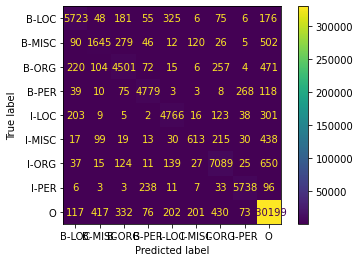

In [21]:
# Confusion maptrix with BIO
ConfusionMatrixDisplay.from_predictions(refs_arr, preds_arr)

plt.rcParams["figure.figsize"] = (20,15)
plt.show()

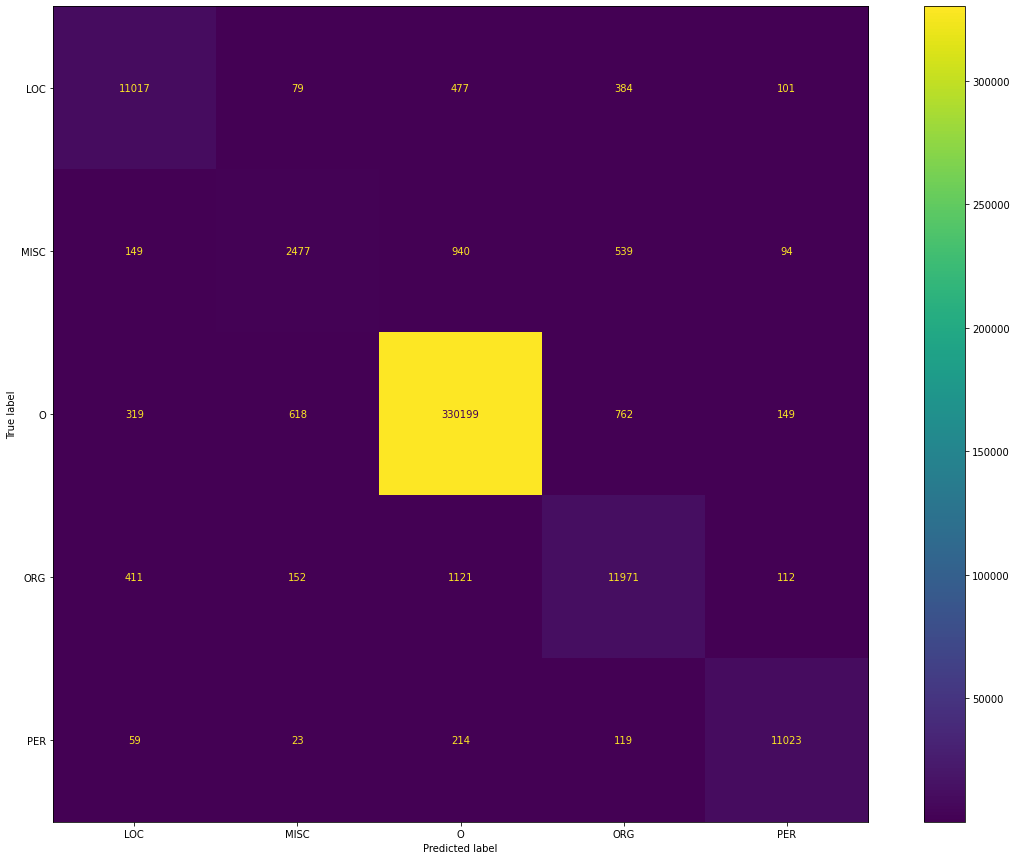

In [22]:
# Confusion maptrix without BIO (B-, I- -> remove)
label_short = {
    'B-LOC': 'LOC',
    'B-MISC': 'MISC',
    'B-ORG': 'ORG',
    'B-PER': 'PER',
    'I-LOC': 'LOC',
    'I-MISC': 'MISC',
    'I-ORG': 'ORG',
    'I-PER': 'PER',
    'O': 'O'
}

refs_arr_transformed = [label_short[ref] for ref in refs_arr]
preds_arr_transformed = [label_short[pred] for pred in preds_arr]

ConfusionMatrixDisplay.from_predictions(refs_arr_transformed, preds_arr_transformed)

plt.rcParams["figure.figsize"] = (8,8)
plt.show()

In [23]:
print(classification_report(refs_arr, preds_arr))

              precision    recall  f1-score   support

       B-LOC       0.89      0.87      0.88      6595
      B-MISC       0.70      0.60      0.65      2725
       B-ORG       0.82      0.80      0.81      5650
       B-PER       0.90      0.90      0.90      5303
       I-LOC       0.87      0.87      0.87      5463
      I-MISC       0.61      0.42      0.50      1474
       I-ORG       0.86      0.87      0.87      8117
       I-PER       0.93      0.94      0.93      6135
           O       0.99      0.99      0.99    332047

    accuracy                           0.98    373509
   macro avg       0.84      0.81      0.82    373509
weighted avg       0.98      0.98      0.98    373509



In [24]:
df_all = pd.DataFrame(embeddings_arr)
df_all

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.805620,-1.049578,1.698440,0.314067,0.752842,-0.699056,-0.557992,1.289075,0.239682,0.262344,...,0.579215,-0.008737,-0.320703,-0.176560,-0.344935,0.216268,0.114831,1.676589,-1.180189,-0.868453
1,-0.851283,-1.200657,1.794140,-0.069582,0.973302,-0.519928,-0.758002,1.002229,0.027974,0.054692,...,0.478669,-0.082779,-0.104683,-0.627129,0.013892,-0.127061,0.227052,1.590145,-1.096828,-0.840095
2,0.297964,-0.057401,0.562733,-0.421187,-1.419896,0.190285,-0.038851,-0.841421,-0.519418,-0.715557,...,0.767633,0.261664,0.022758,-0.325431,-0.394741,0.761507,-0.278565,-0.363790,-0.069266,-0.415932
3,-0.749923,-1.116566,1.315948,-0.261594,0.720223,-0.617823,-0.591496,0.713345,-0.171809,-0.049428,...,0.388767,0.155826,-0.134541,-0.520424,-0.209544,0.003431,0.223571,1.567288,-0.941321,-0.603591
4,-0.167184,-0.582339,0.716835,0.796287,0.633835,0.134524,0.043867,-0.188384,-0.488023,-0.735758,...,0.366912,-0.058969,-0.060172,-0.363857,-0.505128,-0.168996,0.016811,0.904581,-0.968762,0.306264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373504,-0.797188,-1.418229,1.845765,0.233149,1.180360,-0.480428,-0.682252,0.886872,0.287406,0.435460,...,0.457739,-0.019714,-0.077070,-0.619768,-0.097479,-0.266555,0.258235,1.520718,-0.959768,-0.774090
373505,-0.710993,-1.104828,1.685728,0.069263,1.057160,-0.468089,-0.552727,0.725426,0.237664,0.590402,...,0.354299,0.025091,0.027395,-0.636442,-0.292969,-0.160284,0.238394,1.376135,-1.257813,-0.952351
373506,-0.844722,-1.211074,1.656825,0.042032,1.116350,-0.454482,-0.496805,0.927401,0.295113,0.402715,...,0.417689,0.068987,-0.197954,-0.484872,-0.319041,-0.232809,0.200748,1.338123,-1.153281,-0.744750
373507,-0.838739,-1.074656,1.586045,0.044803,0.806956,-0.697836,-0.807326,0.709520,0.307059,0.052528,...,0.328419,0.241341,-0.160113,-0.836293,-0.074068,-0.417193,0.382276,1.556875,-0.898743,-0.881720


In [25]:
lang_color = {
    'en': 'r',
    'zh': 'b',
    'es': 'g',
    'de': 'yellow',
    'nl': 'orange'
}

label_color = {
    'B-LOC': 'r',
    'B-MISC': 'g',
    'B-ORG': 'b',
    'B-PER': 'yellow',
    'I-LOC': 'r',
    'I-MISC': 'g',
    'I-ORG': 'b',
    'I-PER': 'yellow',
    'O': 'orange'
}

label_color_small = {
    'LOC': 'r',
    'MISC': 'g',
    'ORG': 'b',
    'PER': 'yellow',
    'O': 'orange'
}

get_color = lambda i: lang_color[i]
get_label_color = lambda i: label_color[i]
get_diff_color = lambda r,p: 'grey' if r==p else label_color[r]

color_arr = []
color_label_arr = []
color_pred_arr = []
color_diff_arr = []


lang_starting_index = {}

for lang in TRAIN_LANGS:
    print(f"{lang} starts from {len(color_arr)}")
    lang_starting_index[lang] = len(color_arr)
    
    color_arr.extend(list(map(get_color, eval_dict[lang]['langs'])))
    

color_label_arr.extend(list(map(get_label_color, refs_arr)))    
color_pred_arr.extend(list(map(get_label_color, preds_arr)))    
    
color_diff_arr.extend(list(starmap(get_diff_color, zip(refs_arr, preds_arr))))        
    
color_arr = np.array(color_arr)  
color_label_arr = np.array(color_label_arr)  
color_pred_arr = np.array(color_pred_arr)  
color_diff_arr = np.array(color_diff_arr)
words_arr = np.array(words_arr)
refs_arr = np.array(refs_arr)

en starts from 0
zh starts from 46364
es starts from 202376
de starts from 253577
nl starts from 305273


In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
result_2d = pca.fit_transform(df_all)
pca.explained_variance_ratio_

array([0.45092504, 0.08316437])

In [27]:
pca.mean_.shape

(768,)

range(0, 10000)
range(46364, 56364)
range(202376, 212376)
range(253577, 263577)
range(305273, 315273)


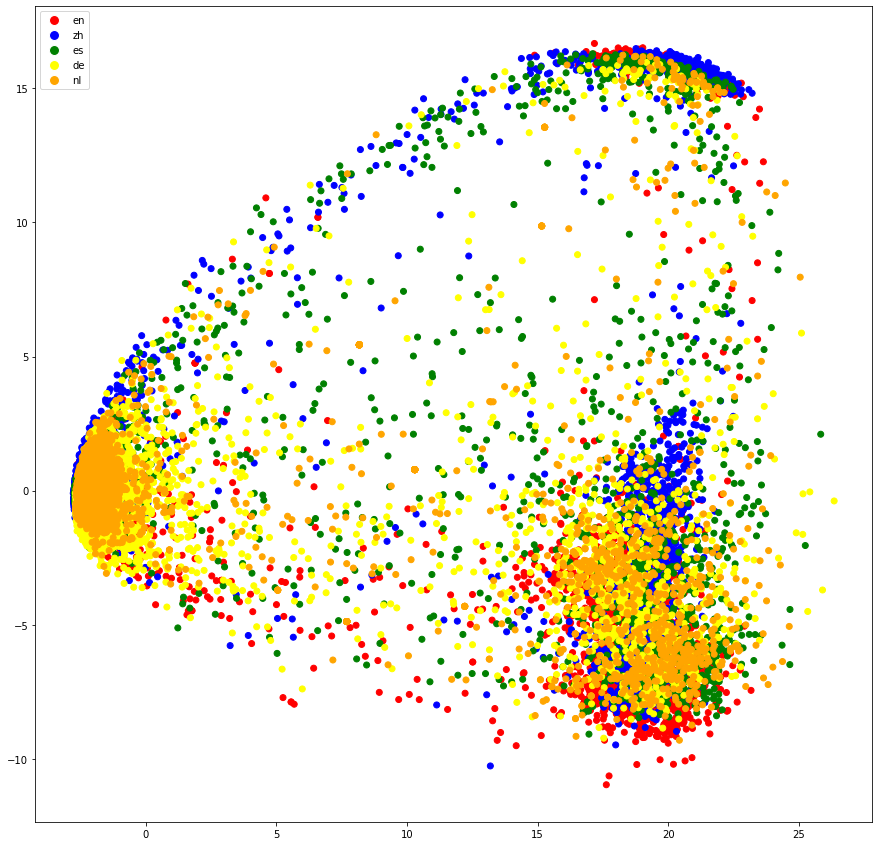

In [28]:
%matplotlib inline


fig, ax = plt.subplots(figsize=(15, 15))

size = 10000
alpha = 1

# create a scatter plot of the projection
for lang in TRAIN_LANGS:
    range_indx = range(lang_starting_index[lang], lang_starting_index[lang] + size)
    print(range_indx)
    #points
    plt.scatter(result_2d[range_indx, 0], result_2d[range_indx, 1], color=color_arr[list(range_indx)].tolist(), alpha=alpha)

    # words
#     for i, word in enumerate(words_arr[list(range_indx)].tolist()):
#         plt.annotate(word, xy=(result_2d[range_indx[i], 0], result_2d[range_indx[i], 1]))
    
    # Labels
#     for i, label in enumerate(refs_arr[list(range_indx)].tolist()):
#         if '-' in label:
#             label = label.split('-')[1]
#         plt.annotate(label, xy=(result_2d[range_indx[i], 0], result_2d[range_indx[i], 1]))

        

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) 
    for l, c in lang_color.items()
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left')
        
plt.show()

range(0, 10000)
range(46364, 56364)
range(202376, 212376)
range(253577, 263577)
range(305273, 315273)


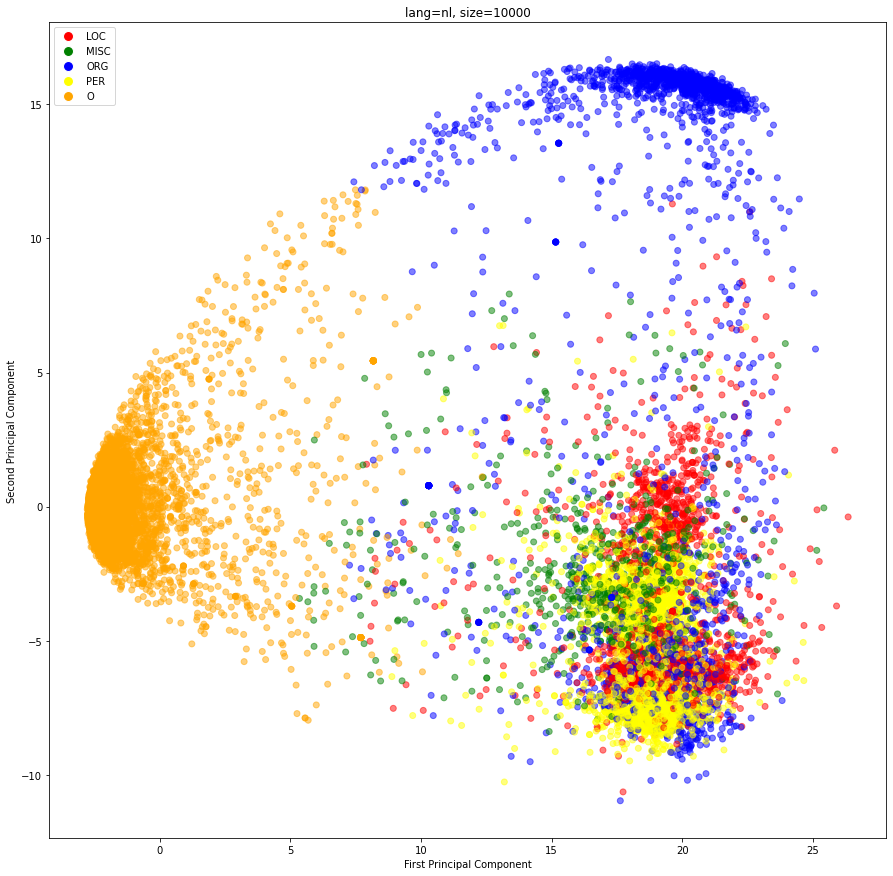

In [29]:
%matplotlib inline


fig, ax = plt.subplots(figsize=(15, 15))

size = 10000
alpha = 0.5

# create a scatter plot of the projection
for lang in TRAIN_LANGS:
    range_indx = range(lang_starting_index[lang], lang_starting_index[lang] + size)
    print(range_indx)
    
    #points
    plt.scatter(result_2d[range_indx, 0], result_2d[range_indx, 1], color=color_pred_arr[list(range_indx)].tolist(), alpha=alpha)
    
    # Decision boundary
#     X1, X2 = np.meshgrid(np.arange(start = result_2d[range_indx, 0].min() - 1, stop = result_2d[range_indx, 0].max() + 1, step = 0.01),
#         np.arange(start = result_2d[range_indx, 1].min() - 1, stop = result_2d[range_indx, 1].max() + 1, step = 0.01))
    
#     plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
#         alpha = 0.5, cmap = ListedColormap(('red', 'green')))
    
    # words
#     for i, word in enumerate(words_arr[list(range_indx)].tolist()):
#         plt.annotate(word, xy=(result_2d[range_indx[i], 0], result_2d[range_indx[i], 1]))
    
    # Labels
#     for i, label in enumerate(refs_arr[list(range_indx)].tolist()):
#         if '-' in label:
#             label = label.split('-')[1]
#         plt.annotate(label, xy=(result_2d[range_indx[i], 0], result_2d[range_indx[i], 1]))

        

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) 
    for l, c in label_color_small.items()
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left')
plt.title(f'lang={lang}, size={size}')
plt.xlabel(f'First Principal Component')
plt.ylabel(f'Second Principal Component')
        
plt.show()

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver='full')
result_3d = pca.fit_transform(df_all)
pca.explained_variance_ratio_

array([0.45092504, 0.08316437, 0.07096491])

<IPython.core.display.Javascript object>


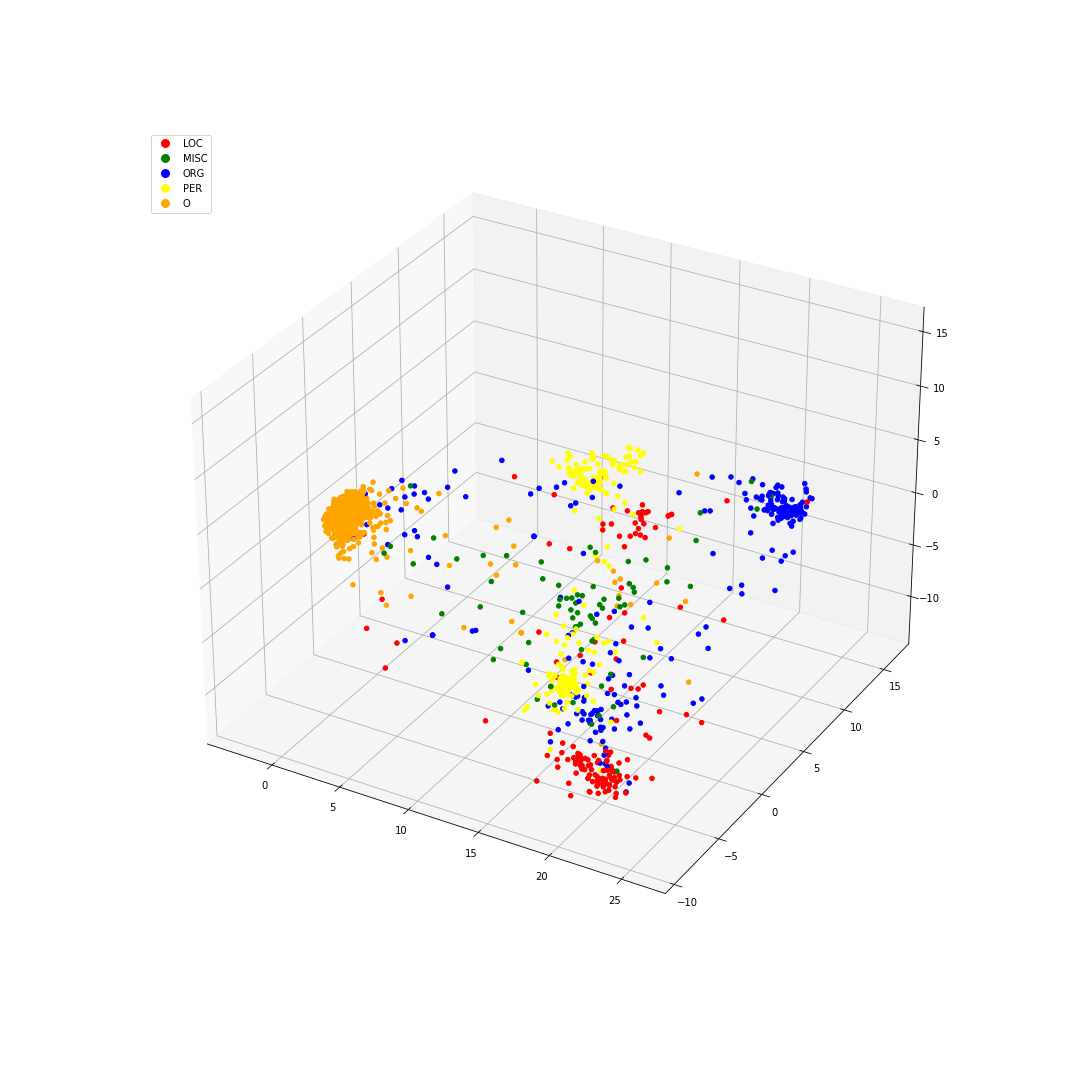

range(0, 1000)
range(46364, 47364)
range(202376, 203376)
range(253577, 254577)
range(305273, 306273)


In [31]:
%matplotlib notebook

plt.rcParams["figure.figsize"] = (15,15)

ax = plt.axes(projection='3d')

ax.grid()

size = 1000
alpha = 1

# create a scatter plot of the projection
for lang in TRAIN_LANGS:
    range_indx = range(lang_starting_index[lang], lang_starting_index[lang] + size)
    print(range_indx)
    
    #points
    ax.scatter(result_3d[range_indx, 0], result_3d[range_indx, 1], result_3d[range_indx, 2], color=color_label_arr[list(range_indx)].tolist(), alpha=alpha)

    # words
#     for i, word in enumerate(words_arr[list(range_indx)].tolist()):
#         plt.annotate(word, xy=(result[range_indx[i], 0], result[range_indx[i], 1]))
    
    # Labels
#     for i, label in enumerate(refs_arr[list(range_indx)].tolist()):
#         if '-' in label:
#             label = label.split('-')[1]
#         ax.text(result_3d[result_3d[i], 0], result_3d[range_indx[i], 1], result_3d[range_indx[i], 2], s=label)
        

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) 
    for l, c in label_color_small.items()
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left')
        
plt.show()

1. Get classifier weights
2. Get centering matrix
    - find mean value of all dims
    - find ceneterd data
    - calc centering matrix
3. Get PCA transformation matrix

In [32]:
# Classifier
path = '/mnt/xtb/knarik/outputs/DG/lang_classifiers/domain_en_de_zh_epoch_50_en_de_zh_epoch_10'

classifier = AutoModelForTokenClassification.from_pretrained(path, output_hidden_states=True, num_labels=3)  

# 3 classifiers
clf_en_w, clf_de_w, clf_zh_w = classifier.classifier.weight.detach().numpy()
clf_en_b, clf_de_b, clf_zh_b = classifier.classifier.bias.detach().numpy()

In [33]:
# #   B-LOC B-MISC B-ORG B-PER I-LOC I-MISC I-ORG I-PER O

# clf_B_LOC_w, _,_,_,_,_,_,_, clf_O_w = model.classifier.weight.detach().cpu().numpy()
# clf_B_LOC_b, _,_,_,_,_,_,_, clf_O_b = model.classifier.bias.detach().cpu().numpy()


# clf_en_w = clf_O_w
# clf_en_b = clf_O_b

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver='full')
result_3d = pca.fit_transform(df_all)
pca.explained_variance_ratio_

array([0.45092504, 0.08316437, 0.07096491])

In [35]:
result_3d.shape

(373509, 3)

In [36]:
# Step 1 Center the data and the boundary plane 
df_all_centered = df_all - pca.mean_

df_all_centered.shape

(373509, 768)

In [37]:
# Step 2: Find centering matrix
M = np.eye(df_all.shape[1] + 1)
M[:, -1][:-1] = -pca.mean_
M.shape

(769, 769)

In [38]:
df_all.shape

(373509, 768)

In [39]:
df_all_argumented = df_all.copy()
df_all_argumented[768] = [1]*df_all.shape[0]
df_all_argumented.shape

(373509, 769)

In [40]:
df_all_centered_with_matrix = np.dot(M, df_all_argumented.T)
df_all_centered_with_matrix = df_all_centered_with_matrix[:-1].T
df_all_centered_with_matrix.shape

(373509, 768)

In [41]:
# check if M matrix is correct
np.allclose(df_all_centered_with_matrix, df_all_centered)

True

In [42]:
clf_en_w_argumented = np.append(clf_en_w, [1])

In [43]:
# apply the same transformation to the boundary line
clf_en_w_transformed = np.dot(clf_en_w_argumented, inv(M)) 
clf_en_w_transformed = clf_en_w_transformed[:-1]??????????????? add the last one also to w_0
clf_en_w_transformed.shape

SyntaxError: invalid syntax (3178294183.py, line 3)

In [ ]:
# Step 3: Find PCA Transformation matrix
# shape (3,373509) X (373509,768)
P = np.dot(result_3d.T, pinv(df_all_centered_with_matrix.T))
P.shape

In [ ]:
pinv(P).shape

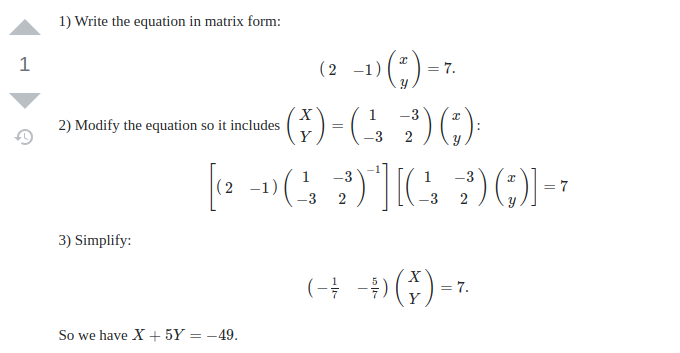

In [ ]:
# new coeffs for boundary line

#(1,3) = (1, 768) X (768,3)
new_ceoffs = np.dot(clf_en_w_transformed, pinv(P))
new_ceoffs

# new boundary line
# so [new_coeffs] * [x1,x2,x3] = - clf_en_b

In [ ]:
# new coeffs for boundary line

#(1,3) = (1, 768) X (768,3)
new_ceoffs = np.dot(clf_en_w_transformed, pinv(P))
new_ceoffs

# new boundary line
# so [new_coeffs] * [x1,x2,x3] = - clf_en_b

In [ ]:
%matplotlib notebook

plt.rcParams["figure.figsize"] = (15,15)

ax = plt.axes(projection='3d')

ax.grid()

size = 20000
alpha = 1

# create a scatter plot of the projection
for lang in TRAIN_LANGS:
    range_indx = range(lang_starting_index[lang], lang_starting_index[lang] + size)
    print(range_indx)
    
    #points
    ax.scatter(result_2d[range_indx, 0], result_2d[range_indx, 1], color=color_pred_arr[list(range_indx)].tolist(), alpha=alpha)
    
    # words
#     for i, word in enumerate(words_arr[list(range_indx)].tolist()):
#         plt.annotate(word, xy=(result[range_indx[i], 0], result[range_indx[i], 1]))
    
    # Labels
#     for i, label in enumerate(refs_arr[list(range_indx)].tolist()):
#         if '-' in label:
#             label = label.split('-')[1]
#         ax.text(result_3d[result_3d[i], 0], result_3d[range_indx[i], 1], result_3d[range_indx[i], 2], s=label)


# boundary for en
boundary_x1 = np.linspace(np.min(result_3d.T[0]), np.max(result_3d.T[0]), 10)
boundary_x2 = np.linspace(np.min(result_3d.T[1]), np.max(result_3d.T[1]), 10)
xx, yy = np.meshgrid(boundary_x1, boundary_x2)
zz = (-clf_en_b - np.dot(new_ceoffs[0], xx) - np.dot(new_ceoffs[1], yy)) / new_ceoffs[2]

ax.plot_surface(xx, yy, zz)        
        

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) 
    for l, c in label_color_small.items()
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left')
        
plt.show()

In [ ]:
%matplotlib notebook

plt.rcParams["figure.figsize"] = (15,15)

ax = plt.axes(projection='3d')

ax.grid()

size = 20000
alpha = 1

# create a scatter plot of the projection
for lang in TRAIN_LANGS:
    range_indx = range(lang_starting_index[lang], lang_starting_index[lang] + size)
    print(range_indx)
    
    #points
    ax.scatter(result_3d[range_indx, 0], result_3d[range_indx, 1], result_3d[range_indx, 2], color=color_arr[list(range_indx)].tolist(), alpha=alpha)

    # words
#     for i, word in enumerate(words_arr[list(range_indx)].tolist()):
#         plt.annotate(word, xy=(result[range_indx[i], 0], result[range_indx[i], 1]))
    
    # Labels
#     for i, label in enumerate(refs_arr[list(range_indx)].tolist()):
#         if '-' in label:
#             label = label.split('-')[1]
#         ax.text(result_3d[result_3d[i], 0], result_3d[range_indx[i], 1], result_3d[range_indx[i], 2], s=label)


# boundary for en
boundary_x1 = np.linspace(np.min(result_3d.T[0]), np.max(result_3d.T[0]), 10)
boundary_x2 = np.linspace(np.min(result_3d.T[1]), np.max(result_3d.T[1]), 10)
xx, yy = np.meshgrid(boundary_x1, boundary_x2)
zz = (-clf_en_b - np.dot(new_ceoffs[0], xx) - np.dot(new_ceoffs[1], yy)) / new_ceoffs[2]

ax.plot_surface(xx, yy, zz-20)        
        

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) 
    for l, c in lang_color.items()
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left')
        
plt.show()